# Forecasting COVID-19 Cases

In [1]:
import os
import sys
# appending main project directory to notebook path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# autocompletion for notebook
%config IPCompleter.greedy=True

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import datetime
from config.main_config import DATA_PATH
from pathlib import Path

In [5]:
from pmdarima import auto_arima
import statsmodels as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

In [6]:
import matplotlib.pyplot as plt

In [7]:
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


# EDA

In [8]:
casesdf = pd.read_csv(Path(DATA_PATH,'CONVENIENT_global_confirmed_cases.csv'))


In [9]:
casesdf.head()

,Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom.10,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,Province/State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
casesdf.iloc[:,0]

0      Province/State
1             1/23/20
2             1/24/20
3             1/25/20
4             1/26/20
            ...      
388           2/13/21
389           2/14/21
390           2/15/21
391           2/16/21
392           2/17/21
Name: Country/Region, Length: 393, dtype: object

## Modelling

In [65]:
# skipping first row (header row) and resetting index to begin at 0
dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
tsdata = pd.DataFrame(casesdf['United Kingdom.10'][1:])
tsdata.index = dates
tsdata.index.freq='d' # setting time frequency to be by date
tsdata = tsdata.rename_axis('Date')
tsdata = tsdata[tsdata.index>'03-01-2020']

# splitting 80% into trainset and 20% into testset
sersplit = round(len(tsdata)*0.8)
traindata = tsdata.iloc[:sersplit]
testdata = tsdata.iloc[sersplit:]

In [66]:
# prediction horizon - how far to forecast
pred_horizon=len(testdata)

In [68]:
model = auto_arima(traindata, seasonal=True, trace=True, trend='t',m=7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=4957.598, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4997.605, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4975.075, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4967.851, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4997.605, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=4961.333, Time=0.55 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=4959.772, Time=0.58 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=4959.598, Time=1.61 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=4959.599, Time=1.46 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=4963.093, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=4958.691, Time=0.94 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=4958.188, Time=1.12 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=4961.493, Time=1.73 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=4957.108, Time=0.57 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  282
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2471.173
Date:                           Fri, 19 Feb 2021   AIC                           4954.346
Time:                                   00:53:40   BIC                           4976.176
Sample:                                        0   HQIC                          4963.101
                                           - 282                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0457      0.089      0.511      0.609      -0.130       0.221
ar.L1          0.3066      0.102      3.015      0.003       0.107       0.506
ma.L1         -0.6853      0.082     -8.336      0.000      -0.846      -0.524
ar.S.L7        0.7129      0.125      5.700      0.000       0.468       0.958
ma.S.L7       -0.5158      0.140     -3.675      0.000      -0.791      -0.241
sigma2      2.541e+06   8.14e+04     31.215      0.000    2.38e+06     2.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5825.03
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              38.83   Skew:                             2.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

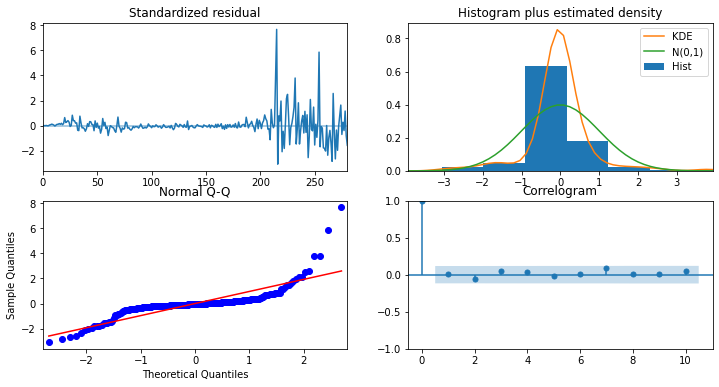

In [17]:
model.plot_diagnostics(figsize=(12,6));

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

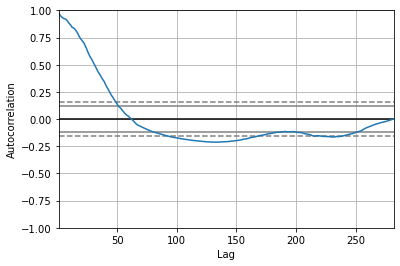

In [18]:
autocorrelation_plot(traindata)

<AxesSubplot:xlabel='Date'>

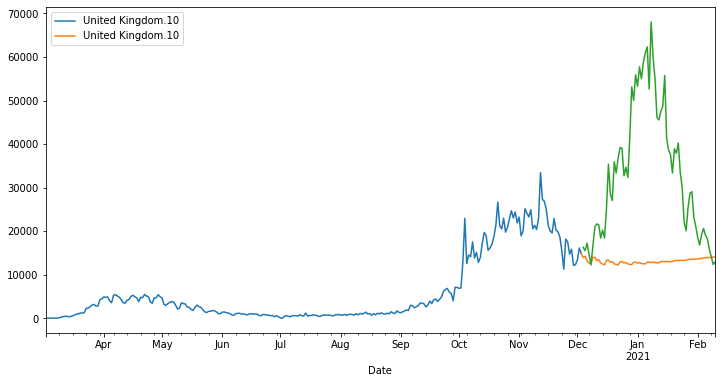

In [79]:
# creating date index as auto_arima only outputs list without index
preddates = pd.date_range(traindata.index[-1],periods=pred_horizon+1,freq=traindata.index.freq)[1:]
pred = pd.Series(model.predict(n_periods=pred_horizon), index=preddates)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)

fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

In [49]:
newmodel = SARIMAX(traindata, order=(2,1,3))
fitresult = newmodel.fit()

pred = fitresult.predict(start=len(traindata), end=len(traindata)+pred_horizon)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)


<AxesSubplot:xlabel='Date'>

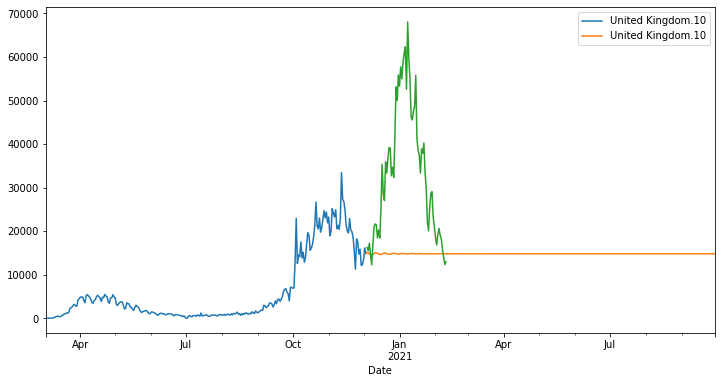

In [50]:
fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

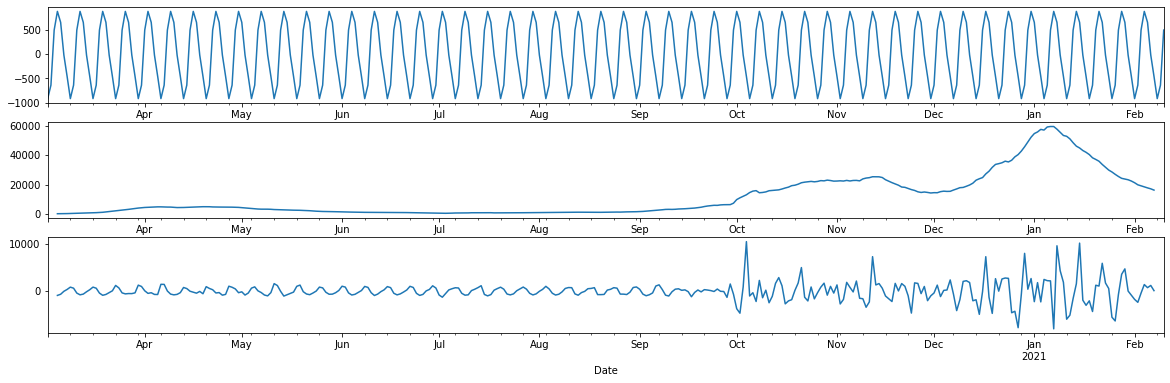

In [74]:
res = seasonal_decompose(tsdata, model='add')
fig, ax = plt.subplots(figsize=(20,6), nrows=3, ncols=1)
res.seasonal.plot(ax=ax[0])
res.trend.plot(ax=ax[1])
res.resid.plot(ax=ax[2])


In [ ]:
newmodel = SARIMAX(traindata, order=(3,1,2))
fitresult = newmodel.fit()

pred = fitresult.predict(start=len(traindata), end=len(traindata)+pred_horizon)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)

In [ ]:
fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

In [ ]:
sm.tsa.adfuller(tempdata)

In [ ]:
hwmodel = ExponentialSmoothing(traindata,trend='add',seasonal='add').fit()

pred = hwmodel.forecast(len(testdata))



<AxesSubplot:xlabel='Date'>

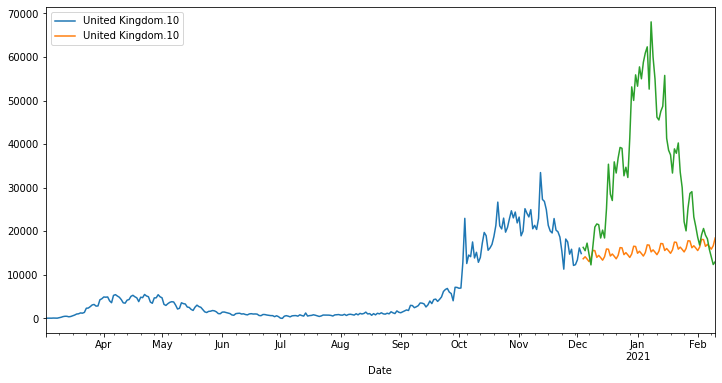

In [176]:
fig, ax = plt.subplots()
traindata.plot(figsize=(12,6),ax=ax)
pred.plot(ax=ax)
testdata.plot(ax=ax)

## App Development

In [13]:
# Load Data
df = px.data.tips()

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )
# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [75]:
def make_prediction(traindf, testdf):
    # make predictions
    pred_horizon = len(testdf)-1
    model = auto_arima(traindf)
    preddates = pd.date_range(traindf.index[-1],periods=pred_horizon+1,freq=traindf.index.freq)[1:]
    pred = pd.Series(model.predict(n_periods=pred_horizon), index=preddates)
    pyhat= pd.Series(traindf.tail(1).squeeze(), index=[traindf.index[-1]]).append(pred)
    pyhat.rename_axis('Date',inplace=True)
    pyhat.rename(traindf.columns[0], inplace=True)

    # merge for plotting
    tsdf = pd.merge(traindf,testdf,how='outer',on='Date')
    tsdf = pd.merge(tsdf, pyhat, how='outer', on='Date')
    tsdf.columns=['Training Data', 'Test Data', 'Forecast']
    
    return tsdf

In [76]:
# Load Data

plotdf = make_prediction(traindata, testdata)



# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("COVID-19 Timeseries Analysis"),
    dcc.Graph(id='graph'),
    html.Label([
        "Country",
        dcc.Dropdown(
            id='country-dropdown', clearable=False,
            value='US', options=[
                {'label': c[0] + c[1], 'value': c[0]}
                for c in zip(casesdf.columns[1:],
                             casesdf.iloc[0,1:].replace(np.nan,'').apply(lambda x:'' if x=='' else ' - '+x))
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("country-dropdown", "value")]
)
def update_figure(country):
    # skipping first row (header row) and resetting index to begin at 0
    dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
    tsdata = pd.DataFrame(casesdf[country][1:])
    tsdata.index = dates
    tsdata.index.freq='d' # setting time frequency to be by date
    tsdata = tsdata.rename_axis('Date')
    tsdata = tsdata[tsdata.index>'03-01-2020']

    # splitting 80% into trainset and 20% into testset
    sersplit = round(len(tsdata)*0.8)
    traindata = tsdata.iloc[:sersplit]
    testdata = tsdata.iloc[sersplit-1:]

    plotdf = make_prediction(traindata,testdata)
    
    fig = px.line(plotdf, title='Confirmed Cases Forecasting', labels={'y':'Confirmed Cases'})
    return fig
# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
hwmodel = ExponentialSmoothing(traindata)
hwres = hwmodel.fit()

In [22]:
len(traindata)

282

In [24]:
hwres.predict(start=282, end=292)

2020-12-09    13419.294632
2020-12-10    13419.294632
2020-12-11    13419.294632
2020-12-12    13419.294632
2020-12-13    13419.294632
2020-12-14    13419.294632
2020-12-15    13419.294632
2020-12-16    13419.294632
2020-12-17    13419.294632
2020-12-18    13419.294632
2020-12-19    13419.294632
Freq: D, dtype: float64

In [25]:
hwres.optimize

array([ True, False, False,  True, False, False])

In [29]:
hwres.summary()

Dep. Variable:,United Kingdom.10,No. Observations:,282
Model:,ExponentialSmoothing,SSE,795632070.003
Optimized:,True,AIC,4192.473
Trend:,None,BIC,4199.757
Seasonal:,None,AICC,4192.617
Seasonal Periods:,None,Date:,"Thu, 18 Feb 2021"
Box-Cox:,False,Time:,14:42:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6382675,alpha,True
initial_level,44.389072,l.0,True


In [144]:
# skipping first row (header row) and resetting index to begin at 0
dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
tsdata = pd.DataFrame(casesdf['US'][1:])
tsdata.index = dates
tsdata.index.freq='d' # setting time frequency to be by date
tsdata = tsdata.rename_axis('Date')
tsdata = tsdata[tsdata.index>'03-01-2020']

# splitting 80% into trainset and 20% into testset
sersplit = round(len(tsdata)*0.8)
traindata = tsdata.iloc[:sersplit]
testdata = tsdata.iloc[sersplit:]
pred_horizon = len(testdata)-1

In [145]:
hwmodel = ExponentialSmoothing(traindata, seasonal='add', trend='add', damped=True)
hwres = hwmodel.fit()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [146]:
pred_data = hwres.predict(start=len(traindata), end=len(traindata)+pred_horizon)

In [147]:
merdf = pd.merge(traindata,testdata,how='outer',on='Date')
merdf.columns = ['Train Data','Test Data']
preddf = pd.DataFrame(pred_data).reset_index()
preddf.columns = ['Date', 'HW_Forecast']
merdf = pd.merge(merdf, preddf, how='outer', on='Date')
merdf.set_index('Date',inplace=True)

In [148]:
px.line(merdf)

In [136]:
hwres.summary()

Dep. Variable:,United Kingdom.10,No. Observations:,282
Model:,ExponentialSmoothing,SSE,778038873.868
Optimized:,True,AIC,4206.167
Trend:,Additive,BIC,4249.870
Seasonal:,Additive,AICC,4207.740
Seasonal Periods:,7,Date:,"Fri, 19 Feb 2021"
Box-Cox:,False,Time:,01:32:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5707143,alpha,True
smoothing_trend,0.0001,beta,True


In [137]:
seasres = seasonal_decompose(traindata)

<AxesSubplot:xlabel='Date'>

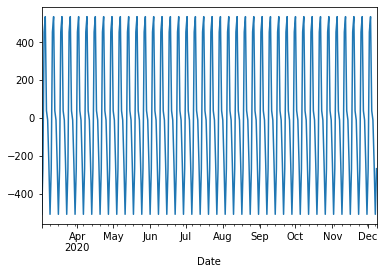

In [138]:
seasres.seasonal.plot()

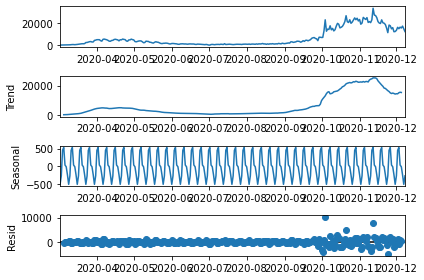

In [139]:
seasres.plot();

In [118]:
from statsmodels.tools.eval_measures import rmspe, rmse

In [143]:
rmse(testdata, pred_data, axis=None)

24068.728692534416

In [142]:
pred_data.values

array([15564.5788321 , 15404.1576015 , 14041.25627459, 14278.06780969,
       13872.62511756, 13031.71122848, 13843.30390959, 15584.19808056,
       15423.58065748, 14060.48510001, 14297.10434685, 13891.47128935,
       13050.36893856, 13861.77504256, 15602.4845022 , 15441.68421491,
       14078.40762186, 14314.84764348, 13909.03715302, 13067.75914359,
       13878.99134554, 15619.52864215, 15458.55791346, 14095.11258343,
       14331.38555543, 13925.40968585, 13083.96795109, 13895.03806497,
       15635.41489439, 15474.28530317, 14110.68269924, 14346.79997009,
       13940.66995636, 13099.07561889, 13909.9946561 , 15650.2219196 ,
       15488.94425813, 14125.19506465, 14361.16721185, 13954.8935257 ,
       13113.15695254, 13923.93517641, 15664.02303471, 15502.60736209,
       14138.72153757, 14374.55842004, 13968.1508218 , 13126.28167569,
       13936.92865232, 15676.88657586, 15515.34226783, 14151.32909426,
       14387.03990116, 13980.50748811, 13138.51477533, 13949.03942097,
      